In [1]:
from astropy.io import fits
from astropy.table import Table

from IPython.display import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

# Examine data

In [2]:
hdu = fits.open('../data/ABCy.fits')
hdu.info()

Filename: ../data/ABCy.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 GroupsHDU       89   (3, 2, 63, 1, 1, 1)   float32   402270 Groups  9 Parameters
  1  AIPS FQ       1 BinTableHDU     28   1R x 5C   [1J, 1D, 1E, 1E, 1J]   
  2  AIPS AN       1 BinTableHDU     62   23R x 13C   [8A, 3D, 0D, 1J, 1J, 1E, 1A, 1E, 1E, 1A, 1E, 1E, 1E]   
  3  AIPS SU       1 BinTableHDU     69   4R x 19C   [1J, 20A, 1J, 4A, 1E, 1E, 1E, 1E, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   


In [3]:
d = hdu[0].data

## Look at the FITS files meta data

In [4]:
metadata_columns = d.columns.names
metadata_columns

['UU',
 'VV',
 'WW',
 'DATE',
 '_DATE',
 'BASELINE',
 'FREQSEL',
 'SOURCE',
 'INTTIM',
 'DATA']

In [5]:

# we only want the first 9, since the last are the data
meta = pd.DataFrame({d.columns.names[i]: d[d.columns.names[i]].byteswap().newbyteorder() for i in range(9)})

In [6]:
# look at a few random data points
meta.sample(3)

,UU,VV,WW,DATE,_DATE,BASELINE,FREQSEL,SOURCE,INTTIM
13792,2.062590e-07,-6.390463e-07,-2.238553e-07,2453688.0,0.949711,1818.0,1.0,1.0,10.0
102646,-2.644534e-07,-1.361624e-07,-2.268738e-08,2453689.0,0.036979,2839.0,1.0,3.0,30.0
59597,4.341481e-07,2.189671e-07,9.130712e-08,2453688.0,0.992419,2071.0,1.0,2.0,10.0


In [7]:
# need to do this because FITS files and Numpy/Pandas hate each other
data = d['DATA'].byteswap().newbyteorder()
data.shape

(402270, 1, 1, 1, 63, 2, 3)

## Remove unnecessary dimensions (`squeeze()` removes all axes of length 1)

In [8]:
# collapse axis so we have the following: rows, channel, polarization, and 'complex'
data = data.squeeze()
data.shape

(402270, 63, 2, 3)

# Focus on Scan 24

In [9]:
# slice out Scan 24 for comparison
idx24 = slice(367103, 381777)

data24 = data[idx24]
meta24 = meta[idx24]

In [10]:
# look at first 5 rows
meta24.head()

,UU,VV,WW,DATE,_DATE,BASELINE,FREQSEL,SOURCE,INTTIM
367103,-5.056181e-07,7.260167e-07,1.231198e-07,2453689.0,0.306076,258.0,1.0,3.0,30.0
367104,-1.057450e-06,1.483011e-06,3.825753e-07,2453689.0,0.306076,259.0,1.0,3.0,30.0
367105,-1.077536e-06,1.619071e-06,9.040557e-09,2453689.0,0.306076,260.0,1.0,3.0,30.0
367106,-1.008528e-06,1.448220e-06,2.453717e-07,2453689.0,0.306076,261.0,1.0,3.0,30.0
367107,-1.379663e-06,2.368600e-06,-1.028087e-06,2453689.0,0.306076,262.0,1.0,3.0,30.0


## Since we're currently only concerned with amplitude information, we can combine the Real and Imaginary parts of the data

In [11]:
# convert to amplitude (ignore weights, phase for now)
data24 = np.sqrt(data24[...,0]**2 + data24[...,1]**2).squeeze()
data24.shape

(14674, 63, 2)

## Figure out baseline combinations, assuming that each antenna pair has unique distance between them

In [12]:
# number of time stamps for each antenna pair
(meta24.BASELINE == 258).sum()

58

In [13]:
# get rows corresponding to the first baseline (which has a distance of 258)
ant00_01 = np.where(meta24.BASELINE == 258)[0]

Note that `[..., 0]` is the same thing as `[:, :, :, 0]`. It's a handy (new) python trick!

In [14]:
# recall that there are 58 time stamps for this baseline
data24_ant0011 = data24[ant00_01]
data24_ant0011.shape

(58, 63, 2)

## Plot all points belong time baseline 00&01 and compare with CASA

In [15]:
# 58 copies of [0, 1, ... 62]
np.repeat(np.arange(63)[np.newaxis], 58, axis=0).shape

(58, 63)

(0, 0.5)

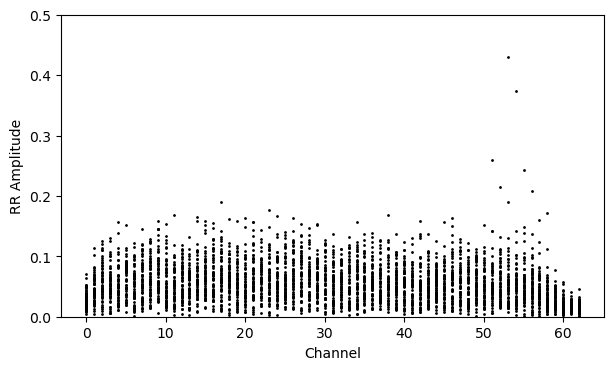

In [16]:
# try channel vs amplitude: first baseline, RR corr, and Real portion
plt.figure(figsize=(7, 4), dpi=100)
plt.scatter(
    x=np.repeat(np.arange(63)[np.newaxis], 58, axis=0), 
    y=data24_ant0011[..., 0], 
    s=1, 
    c='k'
)

plt.xlabel('Channel')
plt.ylabel('RR Amplitude')
plt.ylim(0, 0.5)

Note that I could have done something like:

```python
for idx in ant00_01:
    plt.scatter(range(63), data24[idx, :, 0], s=1, c='k')
```

which would be 100% equivalent. But I don't like `for` loops (they're slow in Python).

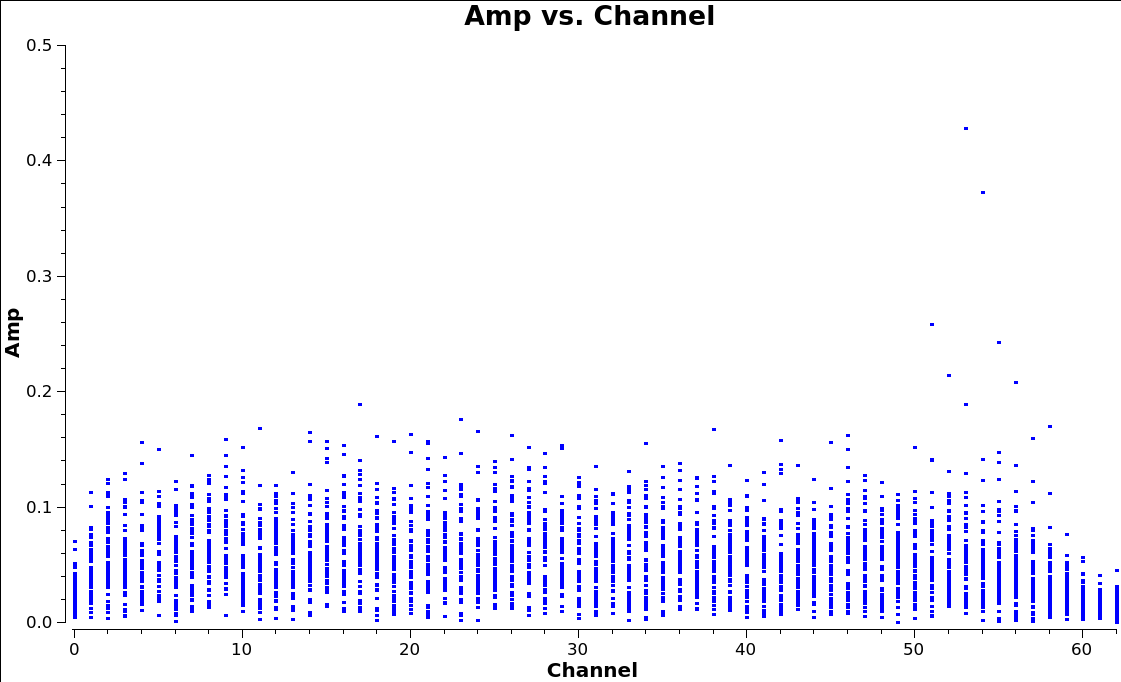

In [17]:
# compare with CASA plot
Image('../images/CASAramp-channel-baseline01.png', width=600)

## Check amplitude vs time

In [18]:
meta24_ant0011 = meta24.iloc[ant00_01]
meta24_ant0011.head()

,UU,VV,WW,DATE,_DATE,BASELINE,FREQSEL,SOURCE,INTTIM
367103,-5.056181e-07,7.260167e-07,1.231198e-07,2453689.0,0.306076,258.0,1.0,3.0,30.0
367356,-5.045292e-07,7.332262e-07,7.539031e-08,2453689.0,0.306424,258.0,1.0,3.0,30.0
367609,-5.046199e-07,7.330509e-07,7.647982e-08,2453689.0,0.306771,258.0,1.0,3.0,30.0
367862,-5.047090e-07,7.328750e-07,7.756945e-08,2453689.0,0.307118,258.0,1.0,3.0,30.0
368115,-5.047954e-07,7.326998e-07,7.865933e-08,2453689.0,0.307465,258.0,1.0,3.0,30.0


In [19]:
times = meta24_ant0011._DATE.values # convert `_DATE` column to numpy array

(0, 0.5)

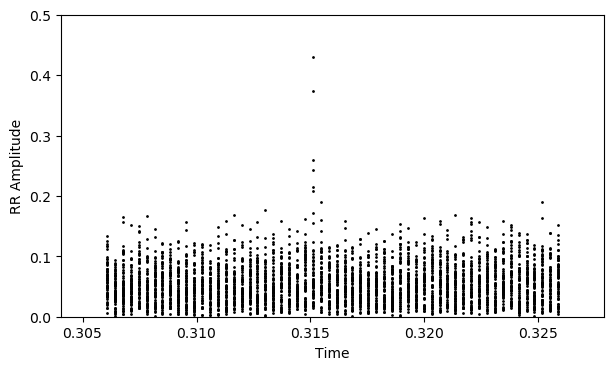

In [20]:
plt.figure(figsize=(7, 4), dpi=100)

plt.scatter(
    x=np.repeat(times[np.newaxis], 63, axis=0),  # we want 63 occurences of these timestamps
    y=data24_ant0011[..., 0].transpose(), 
    s=1, 
    c='k'
)

plt.xlabel('Time')
plt.ylabel('RR Amplitude')
plt.ylim(0, 0.5)

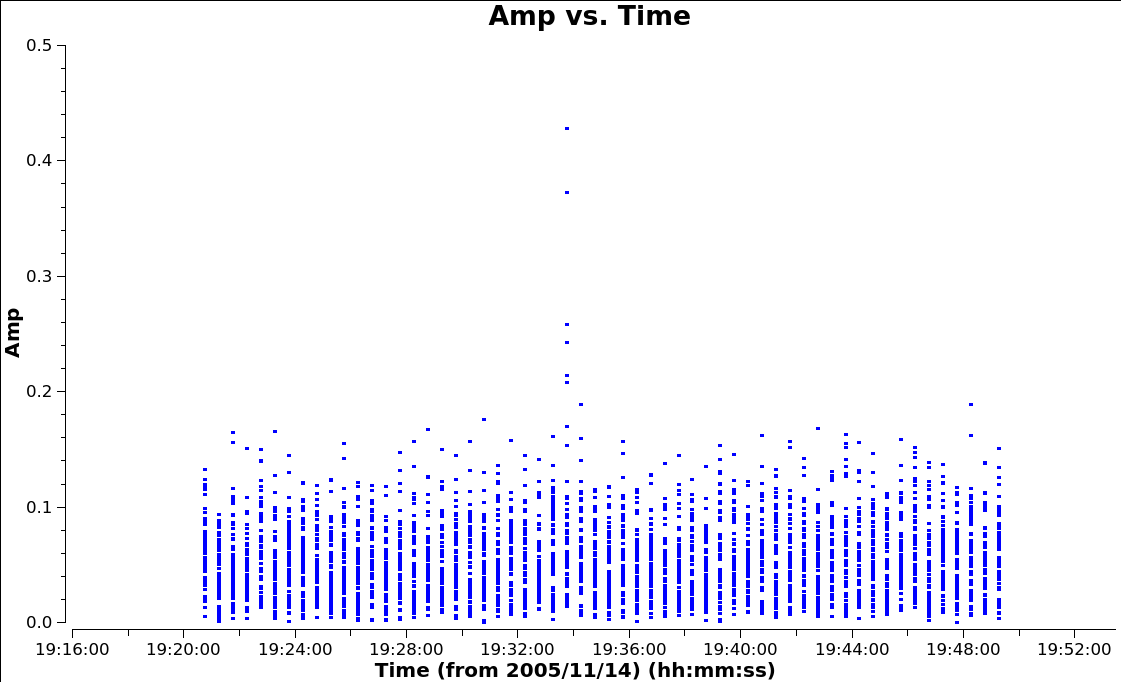

In [21]:
# compare with CASA plot
Image('../images/CASAramp-time-baseline01.png', width=600)

# Viewing the RR and LL amp vs channel vs time as "images"

Text(0.5, 0, 'Channel')

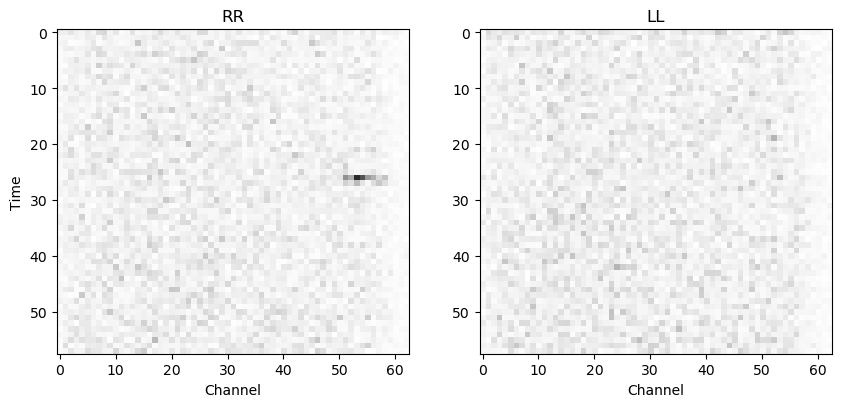

In [22]:
# use `imshow()` to display images

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5), dpi=100)

ax1.set_title('RR')
ax1.imshow(data24_ant0011[...,0], vmin=0, vmax=0.5, cmap='Greys')

ax2.set_title('LL')
ax2.imshow(data24_ant0011[...,1], vmin=0, vmax=0.5, cmap='Greys')

ax1.set_ylabel('Time')
ax1.set_xlabel('Channel')
ax2.set_xlabel('Channel')

# Putting it all together: visualizing more baselines

In [23]:
# find all combinations of baselines, does it equal N * (N-1) / 2?
unique_baselines = np.unique(meta.BASELINE)
print(len(unique_baselines))
print(23 * 22 // 2)

253
253


In [24]:
# get 5 random baselines -- if you rerun this you'll get different baselines!
random_baselines = np.random.choice(unique_baselines, size=5, replace=False)
random_baselines

array([1048., 3866., 4375.,  280.,  787.], dtype=float32)

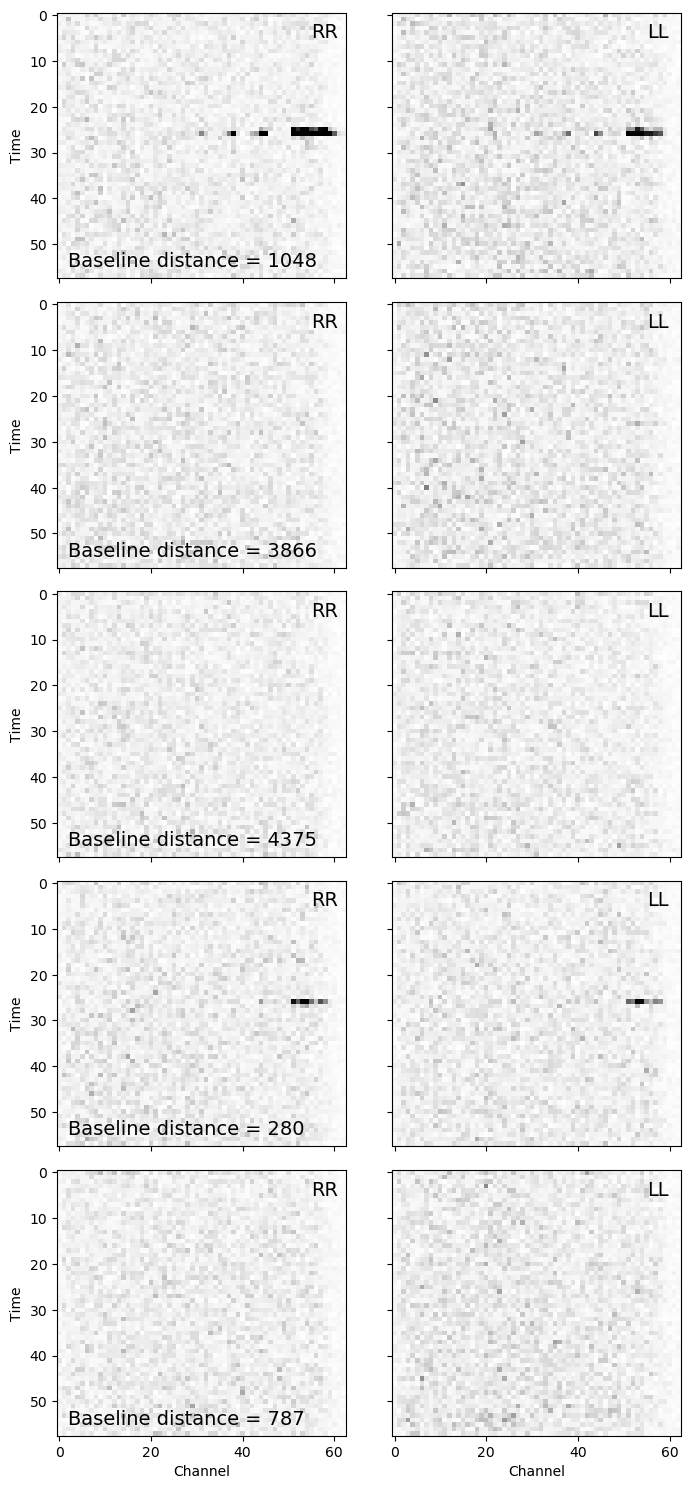

In [25]:
# big demo plot
# =============

# returns a `figure` object plus a 5x2 array of `axis` objects
fig, axes = plt.subplots(5, 2, figsize=(7, 15), dpi=100, sharex=True, sharey=True) 

for ax_pairs, baseline in zip(axes, random_baselines): # iterate through each row, i.e., baseline
    
    # see Section 2.2 for a reminder of how this works
    # each of these are shape (58, 63, 2)
    scan_data = data24[meta24.BASELINE == baseline]        
    
    ax_pairs[0].text(2, 55, 'Baseline distance = {:d}'.format(int(baseline)), fontsize=14)
    
    # recall again that I could just use `scan_data[:, :, 0]` instead of the ellipses
    ax_pairs[0].imshow(scan_data[..., 0], vmin=0, vmax=0.5, cmap='Greys', )    
    ax_pairs[1].imshow(scan_data[..., 1], vmin=0, vmax=0.5, cmap='Greys')
    
    # some useful labels and axis labels
    ax_pairs[0].text(55, 5, 'RR', fontsize=14)
    ax_pairs[1].text(55, 5, 'LL', fontsize=14)
    
    ax_pairs[0].set_ylabel('Time')

axes[-1, 0].set_xlabel('Channel')
axes[-1, 1].set_xlabel('Channel')

fig.tight_layout()
